Replicating the analysis in Beiró et al 2004 with a small twist :)


About the Datasets

    Date format:
    The hour column is computed by integer dividing the timestamp by 3600 seconds. 
    For example, the first line of the network for "noaltarifazo_ruidazonacional" 
    has hour=429531. 
    This means a timestamp of 429531*3600=1546311600 and it implies that the pair 
    of hashtags (h1, h2) was used in the hour comprised between timestamp 1546311600 
    and timestamp 1546315200, which corresponds to "1 January 2019 0:00:00 - 0:00:00". 
    The event itself was centered on 4 January 2019.


Exercise goal - replicate Figure 6(ish) 
- Create a network per hour where:
    Nodes are user and nodes connect when the same hashtags were used between user
- Calculate modularity (use networkix.community) and nestedness

## Load data and import Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import networkx as nx
from nestedness_master.nestedness_calculator import NestednessCalculator

from glob import glob
from tqdm import tqdm

In [5]:
# Data paths
n9_path = 'D:/FV/Personal/VIU/clean_data/9n_9ngranmarchaporlajusticia.csv'
noAlTar_path = 'D:/FV/Personal/VIU/clean_data/noaltarifazo_ruidazonacional.csv'

In [6]:
folder_path = 'D:/FV/Personal/VIU/clean_data/link_lists_after_cleaning/*userNodes*'
files = glob(folder_path)

files = [f for f in files if '.csv' not in f]

complete_df = pd.DataFrame()

for file_path in tqdm(files):

    hour = file_path.split('_link_list.pickle')[0].split('_')[-2]
    database = file_path.split('\\')[-1].split('_')[0]

    with open(file_path, 'rb') as f:
        link_list = pickle.load(f)

    clean_link_list = [tup for tup in link_list if tup[2] != 0]

    clean_link_arr = np.array(clean_link_list)
    nodes = np.concatenate([clean_link_arr[:,0], clean_link_arr[:,1]])

    G = nx.Graph()
    G.add_weighted_edges_from(clean_link_list)

    # Calculate modularity according to louvain method
    louvain_c = nx.community.louvain_communities(G)
    modularity = nx.community.modularity(G, louvain_c)

    # Calculate Nestedness
    mat = nx.adjacency_matrix(G, weight = 'None').todense()
    nestedness = NestednessCalculator(mat).nodf(mat)

    # get components
    components = sorted(nx.connected_components(G), key=len, reverse=True)
    nr_of_components = len(components)

    # Get database
    if database == '9n':
        db_df = pd.read_csv(n9_path)
        db_df['hashtag'] = db_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')
        db_hour_df = db_df[db_df.hour == int(hour)]

    elif database == 'no':
        db_df = pd.read_csv(noAlTar_path)
        db_df['hashtag'] = db_df.hashtag.str.lower(
                        ).str.normalize('NFKD'
                        ).str.encode('ascii', errors='ignore'
                        ).str.decode('utf-8')
        db_hour_df = db_df[db_df.hour == int(hour)]

    # Get nr of users in network
    total_nr_of_hashs = db_hour_df[db_hour_df.user.isin(nodes)].hashtag.count()
    total_nr_of_unique_hashs = db_hour_df[db_hour_df.user.isin(nodes)].hashtag.nunique()

    # Get nr of users per component
    nr_of_hashs_per_c =  [db_hour_df.loc[db_hour_df.user.isin(list(comp)), 'hashtag'].count() for comp in components]
    nr_of_unique_hashs_per_c =  [db_hour_df.loc[db_hour_df.user.isin(list(comp)), 'hashtag'].nunique() for comp in components]

    # Get nr of users in giant component and in network
    nr_of_hashs_in_giant_c = nr_of_hashs_per_c[0]
    nr_of_unique_hashs_in_giant_c = nr_of_unique_hashs_per_c[0]


    # Put Daa in Dataframe
    hour_df = pd.DataFrame([database, hour, modularity, nestedness, nr_of_components, 
                            total_nr_of_hashs, total_nr_of_unique_hashs,
                            nr_of_hashs_in_giant_c, nr_of_unique_hashs_in_giant_c,
                            nr_of_hashs_per_c, nr_of_unique_hashs_per_c]).T

    complete_df = pd.concat([complete_df, hour_df])



complete_df.columns = ['db', 'hour', 'mod', 'nest', 'n_comp', 
                       'total_nr_of_hashs', 'total_nr_of_unique_hashs', 
                       'nr_of_hashs_in_giant_c', 'nr_of_unique_hashs_in_giant_c',
                    'nr_of_hashs_per_c', 'nr_of_unique_hashs_per_c']

complete_df.to_csv('D:/FV/Personal/VIU/clean_data/graph_metrics_userNodes_clean.csv')

complete_df

  5%|▌         | 19/357 [00:40<12:08,  2.16s/it]


KeyboardInterrupt: 

## Figure 6

In [7]:
graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graph_metrics_userNodes_clean.csv'
# graph_metrics_path = 'D:/FV/Personal/VIU/clean_data/graphMetrics_userNodes.csv'

graph_metrics_df = pd.read_csv(graph_metrics_path, index_col=0)

graph_metrics_df['date'] = pd.to_datetime(graph_metrics_df.hour * 3600, unit='s', 
                                          )

graph_metrics_df.head()

,db,hour,mod,nest,n_comp,total_nr_of_hashs,total_nr_of_unique_hashs,nr_of_hashs_in_giant_c,nr_of_unique_hashs_in_giant_c,nr_of_hashs_per_c,nr_of_unique_hashs_per_c,date
0,9n,436984,0.520060,0.124983,13,2203,396,2158,375,"[2158, 4, 2, 2, 9, 7, 3, 2, 4, 3, 4, 3, 2]","[375, 1, 1, 1, 5, 2, 1, 1, 3, 1, 3, 1, 1]",2019-11-07 16:00:00
0,9n,436985,0.536363,0.121459,13,3499,503,3439,477,"[3439, 6, 3, 3, 15, 3, 2, 4, 5, 4, 3, 8, 4]","[477, 4, 1, 1, 7, 2, 1, 1, 3, 2, 1, 2, 1]",2019-11-07 17:00:00
0,9n,436986,0.525303,0.124656,8,2900,404,2857,390,"[2857, 21, 8, 3, 3, 2, 4, 2]","[390, 8, 1, 1, 1, 1, 1, 1]",2019-11-07 18:00:00
0,9n,436987,0.479658,0.146007,13,2896,402,2825,373,"[2825, 8, 20, 6, 4, 3, 4, 3, 2, 2, 4, 12, 3]","[373, 5, 4, 2, 2, 2, 3, 1, 1, 1, 3, 4, 1]",2019-11-07 19:00:00
0,9n,436988,0.467517,0.149453,9,3387,505,3330,470,"[3330, 9, 12, 4, 8, 9, 9, 3, 3]","[470, 5, 5, 1, 6, 7, 8, 2, 1]",2019-11-07 20:00:00


C:\Users\neuro\AppData\Local\Temp\ipykernel_21720\514785624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


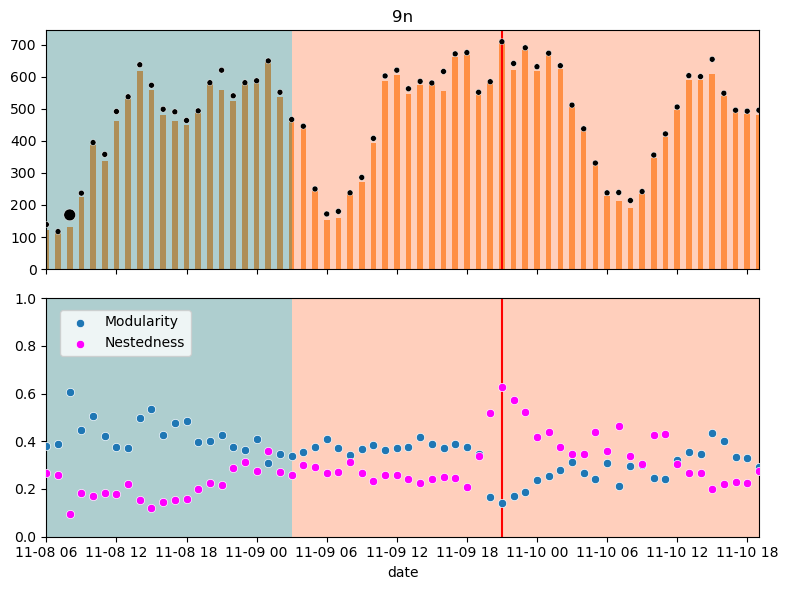

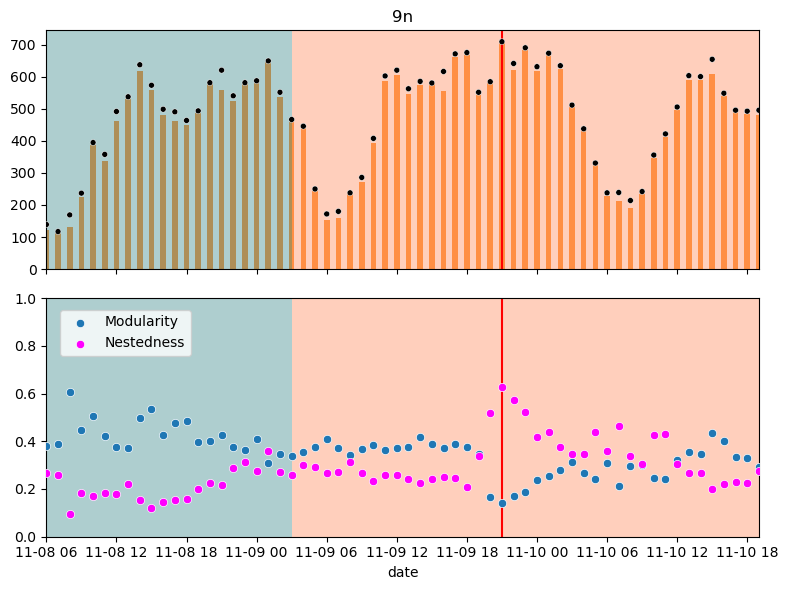

In [8]:
db = '9n'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date <= '2019-11-10 19:00') & 
                             (graph_metrics_df.date >= '2019-11-08 06:00'), :]


def plot_figure6(df, db, total_users = True):

    fig, axes = plt.subplots(2,1, figsize = [8, 6],sharex=True)

    df.loc[:,'high_modularity'] = 'no'
    if total_users:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_hashs > 0.2*df.total_nr_of_hashs.max()), 'high_modularity'] = 'yes'
    else:
        df.loc[(df['mod'] > .55) & (df.total_nr_of_unique_hashs > 0.2*df.total_nr_of_unique_hashs.max()), 'high_modularity'] = 'yes'

    # df1 = df[['date', 'nr_of_unique_hashs_in_giant_c', 'total_nr_of_unique_hashs', 'high_modularity']].melt(id_vars = ['date', 'high_modularity'])
    df1 = df[['date', 'total_nr_of_unique_hashs', 'high_modularity']].melt(id_vars = ['date', 'high_modularity'])
    df1['variable'] = df1.variable.replace({'nr_of_unique_hashs_in_giant_c': 'Nº of hashtags in\nthe giant component',
                                          'total_nr_of_unique_hashs':  'Nº of hashtags'})
    # Axis 0
    sns.scatterplot(data = df1, x = 'date', y = 'value', hue= 'variable', 
                    # style='high_modularity', style_order = ['yes', 'no'],
                    size = 'high_modularity', size_order = ['yes', 'no'],
                    palette = ['black'], zorder = 5, ax = axes[0])
                    # palette = ['red', 'black'], zorder = 5, ax = axes[0])
    
    df2 = df[['date', 'nr_of_unique_hashs_in_giant_c',]]
    axes[0].bar(df2['date'], df2['nr_of_unique_hashs_in_giant_c'], 
                color=sns.color_palette()[1], width=0.02, label = 'Nº of hashtags\nin giant component')
    # axes[0].legend()
    # sns.move_legend(
    #     axes[0], loc='upper left',
    #     bbox_to_anchor=(1, 1), ncol=1, title=None,
    #     frameon=False
    # )
    axes[0].get_legend().remove()

    # sns.scatterplot(data = df, x = 'date', y = 'nr_of_unique_hashs_in_giant_c', style='high_modularity', color = 'red', zorder = 5, ax = axes[0], label = 'Nº of hashtags in\nthe giant component')
    # sns.scatterplot(data = df, x = 'date', y = 'total_nr_of_unique_hashs', style='high_modularity', zorder = 5, color = 'black', ax = axes[0], label = 'Nº of hashtags')
    # Axis 1
    sns.scatterplot(data = df, x = 'date', y = 'mod', zorder = 5, ax = axes[1], label = 'Modularity')
    sns.scatterplot(data = df, x = 'date', y = 'nest', color = 'magenta', zorder = 5, ax = axes[1], label = 'Nestedness')
    # Add Axes spans and annotations
    if db == '9n':
        axes[0].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-11-09 21:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-11-09 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-11-09 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('9n')

    elif db== 'no':
        axes[0].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[0].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[0].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[0].set_xlim([df.date.min(), df.date.max() ]);
        # axes[0].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        # ==========
        axes[1].axvline(x = pd.to_datetime('2019-01-05 00:00'), color = 'red')
        axes[1].axvspan(df.date.min(), '2019-01-04 03:00', facecolor='cadetblue', alpha=0.5)
        axes[1].axvspan('2019-01-04 03:00', df.date.max(), facecolor='lightsalmon', alpha=0.5)
        axes[1].set_xlim([df.date.min(), df.date.max() ]);
        axes[1].set_ylim([0,1]);
        axes[1].legend(bbox_to_anchor=(0.01, 0.98), loc='upper left', )
        for ax in axes:
            ax.set_ylabel('')
        axes[0].set_title('No al tarifazo')

    plt.tight_layout()
    return fig, axes

fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n.png',transparent=True,bbox_inches='tight',pad_inches=0)

fig, axes = plot_figure6(df, db, total_users=True)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_clean_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)

C:\Users\neuro\AppData\Local\Temp\ipykernel_22984\1128629965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_modularity'] = 'no'
C:\Users\neuro\AppData\Local\Temp\ipykernel_22984\1128629965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['high_modularity'] = 'no'


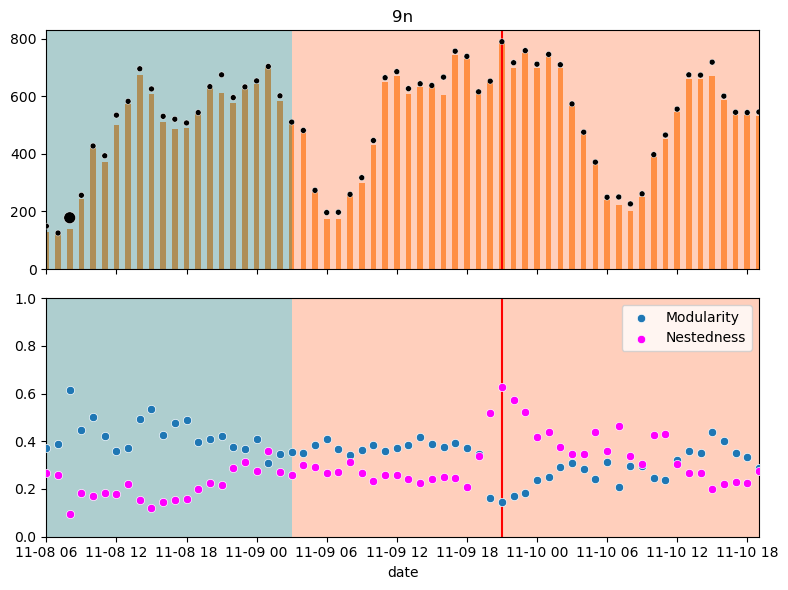

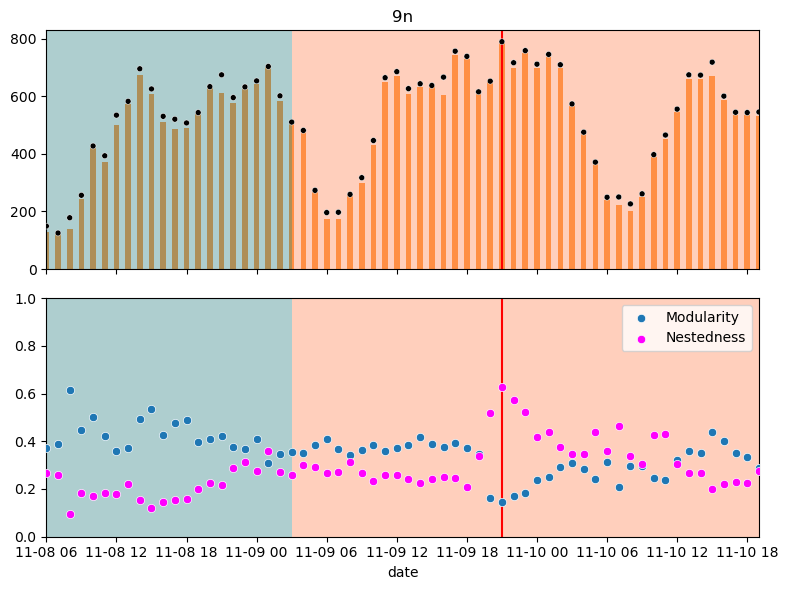

In [9]:
def plot_figure6(df, db, total_users=True):
    # Set up a 2-row plot, sharing the x-axis
    fig, axes = plt.subplots(2, 1, figsize=[8, 6], sharex=True)

    # Label high-modularity based on modularity score and either total or unique hashtags
    df['high_modularity'] = 'no'
    threshold = 0.2 * (df.total_nr_of_hashs.max() if total_users else df.total_nr_of_unique_hashs.max())
    if total_users:
        df.loc[(df['mod'] > 0.55) & (df.total_nr_of_hashs > threshold), 'high_modularity'] = 'yes'
    else:
        df.loc[(df['mod'] > 0.55) & (df.total_nr_of_unique_hashs > threshold), 'high_modularity'] = 'yes'

    # Prepare data for plotting unique hashtag counts
    df1 = df[['date', 'total_nr_of_unique_hashs', 'high_modularity']].melt(id_vars=['date', 'high_modularity'])
    df1['variable'] = df1['variable'].replace({
        'nr_of_unique_hashs_in_giant_c': 'Nº of hashtags in\nthe giant component',
        'total_nr_of_unique_hashs': 'Nº of hashtags'
    })

    # Scatter plot for unique hashtags (Axis 0)
    sns.scatterplot(data=df1, x='date', y='value', hue='variable', 
                    size='high_modularity', size_order=['yes', 'no'],
                    palette=['black'], zorder=5, ax=axes[0])

    # Bar plot for hashtags in giant component (Axis 0)
    df2 = df[['date', 'nr_of_unique_hashs_in_giant_c']]
    axes[0].bar(df2['date'], df2['nr_of_unique_hashs_in_giant_c'], color=sns.color_palette()[1], width=0.02,
                label='Nº of hashtags\nin giant component')
    axes[0].get_legend().remove()  # Remove legend from first plot

    # Scatter plot for modularity and nestedness (Axis 1)
    sns.scatterplot(data=df, x='date', y='mod', zorder=5, ax=axes[1], label='Modularity')
    sns.scatterplot(data=df, x='date', y='nest', color='magenta', zorder=5, ax=axes[1], label='Nestedness')

    # Customize x-axis shading and labels based on dataset type
    if db == '9n':
        cutoff_date = pd.to_datetime('2019-11-09 03:00')
        highlight_date = pd.to_datetime('2019-11-09 21:00')
        title = '9n'
    elif db == 'no':
        cutoff_date = pd.to_datetime('2019-01-04 03:00')
        highlight_date = pd.to_datetime('2019-01-05 00:00')
        title = 'No al tarifazo'
    
    # Apply date-specific annotations and formatting
    for ax in axes:
        ax.axvline(x=highlight_date, color='red')  # Vertical line for highlight date
        ax.axvspan(df.date.min(), cutoff_date, facecolor='cadetblue', alpha=0.5)
        ax.axvspan(cutoff_date, df.date.max(), facecolor='lightsalmon', alpha=0.5)
        ax.set_xlim([df.date.min(), df.date.max()])
        ax.set_ylabel('')

    # Set y-axis limits and title for the second plot
    axes[1].set_ylim([0, 1])
    axes[0].set_title(title)

    plt.tight_layout()
    return fig, axes

fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n.png',transparent=True,bbox_inches='tight',pad_inches=0)

fig, axes = plot_figure6(df, db, total_users=True)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_clean_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_9n_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)

C:\Users\neuro\AppData\Local\Temp\ipykernel_5092\514785624.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'high_modularity'] = 'no'


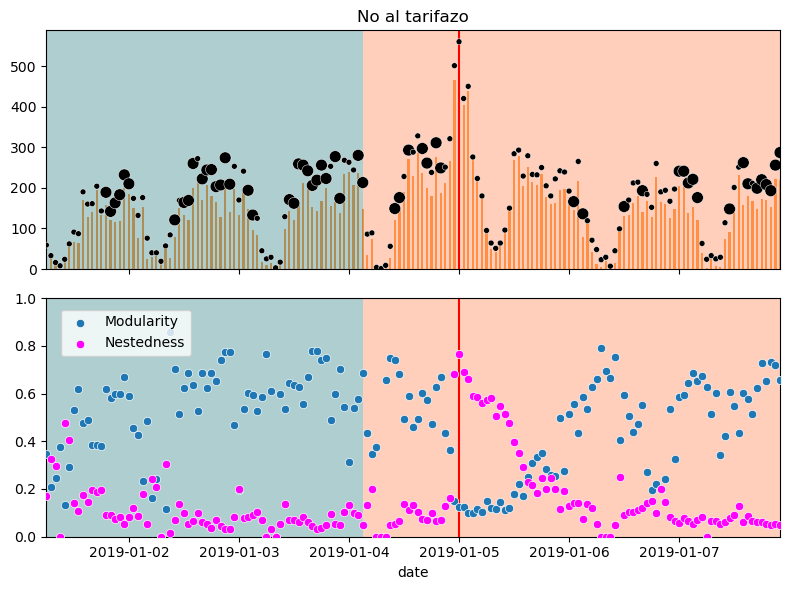

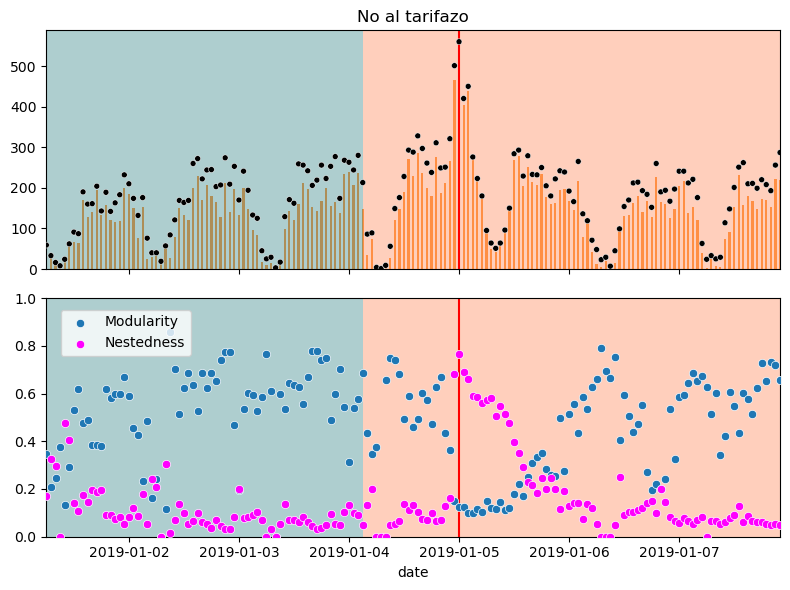

In [41]:

db = 'no'

df = graph_metrics_df.loc[(graph_metrics_df.db == db) & 
                             (graph_metrics_df.date >= '2019-01-01 06:00') & 
                             (graph_metrics_df.date <= '2019-01-07 22:00'), :]


fig, axes = plot_figure6(df, db, total_users=False)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_no_al_tarifazo_clean.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_no_al_tarifazo.png',transparent=True,bbox_inches='tight',pad_inches=0)

fig, axes = plot_figure6(df, db, total_users=True)
plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_no_al_tarifazo_clean_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)
# plt.savefig('D:/FV/Personal/VIU/figures/f6_userNodes_no_al_tarifazo_totalHashs.png',transparent=True,bbox_inches='tight',pad_inches=0)